In [101]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
from keras.utils import normalize

In [102]:
pip install tensorflow

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow
Note: you may need to restart the kernel to use updated packages.


In [103]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [111]:
path = '/Users/sahilapte/Desktop/datasets/archive/video55'

In [112]:
images = []
masks = []

In [113]:
HEIGHT = 256
WIDTH =256

In [114]:
#imcount = 0
#lcount = 0

In [115]:
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        im = os.path.join(dirname, filename)
        if 'endo.png' in im :
            img = cv2.imread(im, 0)
            img = cv2.resize(img, (HEIGHT,WIDTH))
            img = np.array(img)
            images.append(img)
        elif 'endo_color_mask.png'in im:
            img = cv2.imread(im, 0) 
            img = cv2.resize(img, (HEIGHT,WIDTH), interpolation = cv2.INTER_NEAREST)
            img = np.array(img)
            masks.append(img)

In [116]:
len(images)

240

In [117]:
len(masks)

240

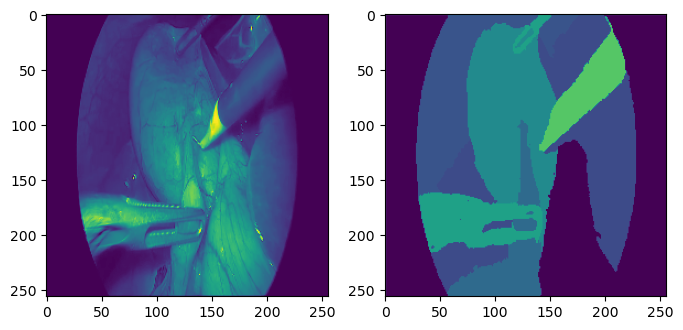

In [118]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(images[0])
ax[1].imshow(masks[0])
plt.show()

In [119]:
images = np.array(images)
masks = np.array(masks)

In [120]:
images.shape

(240, 256, 256)

In [121]:
from sklearn.preprocessing import LabelEncoder

In [122]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = masks.shape
reshaped = masks.reshape(-1,1)
encoded = labelencoder.fit_transform(reshaped)
original_shape = encoded.reshape(n, h, w)

np.unique(original_shape)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [123]:
n_classes = 8

In [124]:
train_images = np.expand_dims(images, axis=3)

In [125]:
train_images = normalize(train_images, axis=1)

In [126]:
train_masks_input = np.expand_dims(original_shape, axis=3)

In [127]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, train_masks_input, test_size = 0.10, random_state = 0)

In [128]:
X_train.shape

(216, 256, 256)

In [129]:
X_test.shape

(24, 256, 256)

In [130]:
from keras.utils import to_categorical

In [131]:
train_masks_cat = to_categorical(y_train, num_classes=n_classes,dtype='float32')
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

In [132]:
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [133]:
#from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                       # classes = np.unique(encoded),
                                       # y = encoded )

In [134]:
#print("Class weights:", class_weights)

In [135]:
def multi_unet_model(n_classes=8, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    
    
    return model

In [136]:
model = multi_unet_model()

In [137]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 256, 256, 16  160         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_27 (Dropout)           (None, 256, 256, 16  0           ['conv2d_57[0][0]']              
                                )                                                           

                                                                                                  
 conv2d_71 (Conv2D)             (None, 128, 128, 32  18464       ['concatenate_14[0][0]']         
                                )                                                                 
                                                                                                  
 dropout_34 (Dropout)           (None, 128, 128, 32  0           ['conv2d_71[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_72 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_34[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_tr

In [139]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 256, 256, 16  160         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_27 (Dropout)           (None, 256, 256, 16  0           ['conv2d_57[0][0]']              
                                )                                                           

                                                                                                  
 conv2d_71 (Conv2D)             (None, 128, 128, 32  18464       ['concatenate_14[0][0]']         
                                )                                                                 
                                                                                                  
 dropout_34 (Dropout)           (None, 128, 128, 32  0           ['conv2d_71[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_72 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_34[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_tr

In [140]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=185, 
                    validation_data=(X_test, y_test_cat)) 

Epoch 1/185


2022-12-13 20:38:00.203821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 15.5932 - accuracy: 0.1437

2022-12-13 20:38:06.226180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 7s 416ms/step - loss: 15.5932 - accuracy: 0.1437 - val_loss: 2.7022 - val_accuracy: 0.2750
Epoch 2/185
14/14 [==============================] - 5s 340ms/step - loss: 3.4456 - accuracy: 0.2555 - val_loss: 2.0548 - val_accuracy: 0.3539
Epoch 3/185
14/14 [==============================] - 5s 339ms/step - loss: 2.0396 - accuracy: 0.3023 - val_loss: 1.8651 - val_accuracy: 0.3717
Epoch 4/185
14/14 [==============================] - 5s 343ms/step - loss: 1.6329 - accuracy: 0.3719 - val_loss: 1.6912 - val_accuracy: 0.3850
Epoch 5/185
14/14 [==============================] - 5s 340ms/step - loss: 1.5369 - accuracy: 0.3822 - val_loss: 1.5452 - val_accuracy: 0.3878
Epoch 6/185
14/14 [==============================] - 5s 347ms/step - loss: 1.4943 - accuracy: 0.4285 - val_loss: 1.4961 - val_accuracy: 0.4764
Epoch 7/185
14/14 [==============================] - 5s 342ms/step - loss: 1.4743 - accuracy: 0.4718 - val_loss: 1.4805 - val_accuracy: 0.4771
Epoch 8/18

14/14 [==============================] - 7s 470ms/step - loss: 0.9652 - accuracy: 0.6567 - val_loss: 0.9769 - val_accuracy: 0.6580
Epoch 59/185
14/14 [==============================] - 7s 490ms/step - loss: 0.9544 - accuracy: 0.6587 - val_loss: 0.9833 - val_accuracy: 0.6653
Epoch 60/185
14/14 [==============================] - 6s 441ms/step - loss: 0.9525 - accuracy: 0.6601 - val_loss: 0.9564 - val_accuracy: 0.6719
Epoch 61/185
14/14 [==============================] - 6s 421ms/step - loss: 0.9410 - accuracy: 0.6628 - val_loss: 0.9496 - val_accuracy: 0.6647
Epoch 62/185
14/14 [==============================] - 6s 430ms/step - loss: 0.9417 - accuracy: 0.6604 - val_loss: 0.9429 - val_accuracy: 0.6606
Epoch 63/185
14/14 [==============================] - 6s 432ms/step - loss: 0.9400 - accuracy: 0.6625 - val_loss: 0.9637 - val_accuracy: 0.6590
Epoch 64/185
14/14 [==============================] - 6s 418ms/step - loss: 0.9175 - accuracy: 0.6714 - val_loss: 0.9974 - val_accuracy: 0.6563
Epoch

Epoch 115/185
14/14 [==============================] - 6s 418ms/step - loss: 0.5271 - accuracy: 0.8226 - val_loss: 0.6436 - val_accuracy: 0.7750
Epoch 116/185
14/14 [==============================] - 6s 420ms/step - loss: 0.5252 - accuracy: 0.8225 - val_loss: 0.6606 - val_accuracy: 0.7740
Epoch 117/185
14/14 [==============================] - 6s 420ms/step - loss: 0.5105 - accuracy: 0.8258 - val_loss: 0.6447 - val_accuracy: 0.7802
Epoch 118/185
14/14 [==============================] - 6s 425ms/step - loss: 0.5113 - accuracy: 0.8259 - val_loss: 0.6283 - val_accuracy: 0.7870
Epoch 119/185
14/14 [==============================] - 6s 428ms/step - loss: 0.5158 - accuracy: 0.8259 - val_loss: 0.6246 - val_accuracy: 0.7833
Epoch 120/185
14/14 [==============================] - 6s 424ms/step - loss: 0.5138 - accuracy: 0.8241 - val_loss: 0.6551 - val_accuracy: 0.7664
Epoch 121/185
14/14 [==============================] - 6s 425ms/step - loss: 0.5181 - accuracy: 0.8206 - val_loss: 0.6684 - val_ac

14/14 [==============================] - 6s 397ms/step - loss: 0.3708 - accuracy: 0.8664 - val_loss: 0.6167 - val_accuracy: 0.7924
Epoch 172/185
14/14 [==============================] - 6s 397ms/step - loss: 0.3612 - accuracy: 0.8712 - val_loss: 0.5909 - val_accuracy: 0.7973
Epoch 173/185
14/14 [==============================] - 6s 397ms/step - loss: 0.3623 - accuracy: 0.8701 - val_loss: 0.5996 - val_accuracy: 0.7993
Epoch 174/185
14/14 [==============================] - 6s 395ms/step - loss: 0.3588 - accuracy: 0.8708 - val_loss: 0.6276 - val_accuracy: 0.7875
Epoch 175/185
14/14 [==============================] - 6s 395ms/step - loss: 0.3656 - accuracy: 0.8685 - val_loss: 0.6230 - val_accuracy: 0.7853
Epoch 176/185
14/14 [==============================] - 6s 396ms/step - loss: 0.3653 - accuracy: 0.8705 - val_loss: 0.6270 - val_accuracy: 0.7978
Epoch 177/185
14/14 [==============================] - 6s 400ms/step - loss: 0.3660 - accuracy: 0.8678 - val_loss: 0.5845 - val_accuracy: 0.7980

In [143]:
model.save('185ev55.h5')

In [144]:
param, acc = model.evaluate(X_test, y_test_cat)

1/1 [==============================] - 0s 318ms/step - loss: 0.6005 - accuracy: 0.7932


In [145]:
print("Accuracy is = ", (acc * 100.0), "%")

Accuracy is =  79.31734919548035 %


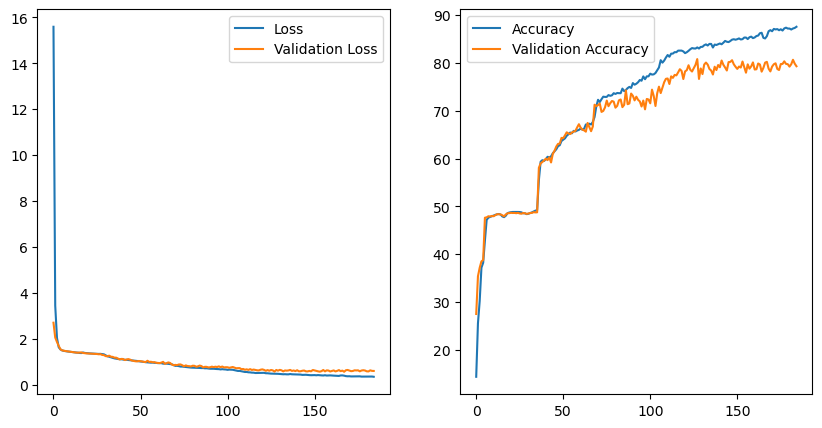

In [146]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(history.history['loss'], '-', label = 'Loss')
ax1.plot(history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(history.history['accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(history.history['val_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

In [147]:
y_test_cat.shape

(24, 256, 256, 8)